# Predictor Explainer

The following Python code runs after the user has selected all the `X`'s, `y`, `Datetime` (optional), `Weights` (optional) and other parameters. [PyJMP](https://github.com/industrial-data/pyJMP) needs to be installed.

The main idea is to find variables (`X`'s or tags) that correlate with at certain target (`y`). Intentionally, the purpose is to generate **descriptive models** to find interesting variables to visualize.

More information can be found here:

* [Predictor Explainer](https://github.com/industrial-data/predictor-explainer/pyJMP)
* [Industrial data science – a review of machine learning applications for chemical and process industries](https://pubs.rsc.org/en/content/articlelanding/2022/re/d1re00541c)


In [1]:
__author__ = 'Francisco Navarro; Juline Gillard'
__license__ = "BSD Clause-3"
__version__ = '2022.10.30'
__maintainer__ = 'Francisco Navarro; Carlos Perez-Galvan'
__status__ = 'beta'
__url__ = 'https://github.com/industrial-data/predictor-explainer'

# Loading Python libraries

In [2]:
import numpy as np
import pandas as pd
import shap
import umap
import hdbscan
from lightgbm.sklearn import LGBMRegressor
import matplotlib.pyplot as plt
import time
import os
import re

# To deactivate plots, change to False
is_plotting = True

if is_plotting:
    import umap.plot

# Loading data from temp files (saved by JMP)

<div class="alert alert-block alert-warning">New CSV files are generated only when the user clicks OK in the Predictor Explainer add-in.</div>

In [3]:
temp_data_path = os.path.join(os.path.join(os.environ['USERPROFILE']),
                             'AppData',
                             'Local',
                             'Temp')
print(temp_data_path)

C:\Users\fxn0478\AppData\Local\Temp


In [4]:
y_path_csv = os.path.join(temp_data_path,'y.csv')
X_path_csv = os.path.join(temp_data_path,'X.csv')
t_path_csv = os.path.join(temp_data_path,'t.csv')
W_path_csv = os.path.join(temp_data_path,'W.csv')
user_parameters_csv = os.path.join(temp_data_path,'user_parameters.csv')

is_unspervised_learning = False

try:
    y = pd.read_csv(y_path_csv)
except:
    print("target column couldn't be loaded correctly, assuming unspervised learning ")
    is_unspervised_learning = True

try:
    X = pd.read_csv(X_path_csv)
    JMP_row_index = X['row_index'].copy();
    del X['row_index']
    
except Exception:
    print("X columns couldn't be loaded correctly, make sure they exist")    

try:
    t = pd.read_csv(t_path_csv)
except:
    print('Time column was not defined by user')
    
try:
    W = pd.read_csv(W_path_csv)
except:
    print('Weights were not defined by user')

try:
    JMP_user_parameters = pd.read_csv(user_parameters_csv)
except:
    print('User parameters not defined')

Weights were not defined by user


In [5]:
print('Options defined in JMP addin: \n\n', JMP_user_parameters);

Options defined in JMP addin: 

    nTrees  SignalToNoiseRatio  NdimUMAP     metric  nrows
0     100            0.000001         2  euclidean      1


In [6]:
# This function will be used at the end to create umap from RF selected features
def umap_princ_components(X, n_umap_components=2, distance='euclidean'):
    '''Takes not scaled X(obs,variables) and reduces to n_comp dimensions
    by using umap reducer embedding.
    
    It returns a dataframe with the following columns:
        n_comp (embeddings)
        euclidan distance between consecutive rows
        sum(n_comp)
        labels for clusters
        outlier score based on density'''
    
    #n_umap_components = 2 # default and paper
    
    print('N of umap dimensions', n_umap_components)
    print('Distance metric:', distance)
    
    # Data prep
    
    # Umap does not handle NaNs (TODO improve)
    # Simplest time series approach:
    # forward filled and then back filled
    # (!) Not compatible with batch data
    X_unsupervised = X.copy()
    
    X_unsupervised = X_unsupervised.fillna(method='ffill')
    X_unsupervised = X_unsupervised.fillna(method='bfill')
    
    # Drops any reamining column with of empty values
    X_unsupervised = X_unsupervised.dropna(axis=1, how='all')
    
    # Robust normalization
    X_unsupervised_normalized = ((X_unsupervised-X_unsupervised.quantile(0.03)) /
                                 (X_unsupervised.quantile(0.97)-X_unsupervised.quantile(0.03)))
    
    # If values are fairly constant, (q97-q03) division returns NaN (TODO improve)
    X_unsupervised_normalized = X_unsupervised_normalized.dropna(axis=1, how='any')

    X_unsupervised_normalized = X_unsupervised_normalized.clip(0, 1)
    
    # Dimensionality reduction
    
    # Choice of parameters is indicated but also shared with
    # paper https://doi.org/10.1016/j.conengprac.2019.104189
    
    # TODO Exploit AlignedUMAP for time varying data
    # https://umap-learn.readthedocs.io/en/latest/aligned_umap_politics_demo.html
    
    if distance == 'euclidean':
        y_distance = 'l2'
    
    if distance == 'manhattan':
        y_distance = 'l1'
        
    if is_unspervised_learning:
    
        embedding = umap.UMAP(n_neighbors=15, # default and paper
                            min_dist=0.1, # default and paper
                            n_components=n_umap_components,
                            metric=distance,
                            output_metric=distance,
                            target_metric=y_distance,
                            #random_state=42, # uncomment to get slower but reproducible results
                            ).fit(X_unsupervised_normalized)
    else:
        embedding = umap.UMAP(n_neighbors=15, # default and paper
                            min_dist=0.1, # default and paper
                            n_components=n_umap_components,
                            metric=distance,
                            output_metric=distance,
                            target_metric=y_distance,
                            #random_state=42, # uncomment to get slower but reproducible results
                            ).fit(X_unsupervised_normalized, y=y) #add 'y' as function input
        
        
        
    # Generating umap column names
    umap_col_names = ['umap'+str(i+1) for i in range(n_umap_components)]
    
    # Saving table
    array_umap_components = embedding.embedding_
    df_umap = pd.DataFrame(array_umap_components, columns=umap_col_names)
    

    
    # Clustering and density analysis 

    n_observations = len(X_unsupervised_normalized.index)
    percentual_threshold = 0.05 # % of data required to form cluster 

    # array_umap_components = df_umap.iloc[:,:n_umap_components].values

    clusterer = hdbscan.HDBSCAN(
                        min_samples=5,
                        min_cluster_size=round(percentual_threshold*n_observations),
                        ).fit(array_umap_components)

    labels = clusterer.labels_  

    are_clustered = (labels >= 0) #-1 are unclustered points
    
    df_umap['umap_clusters'] = labels
    df_umap['outlier_score'] = clusterer.outlier_scores_
    
    # Row or time difference
    diff_period = int(JMP_user_parameters['nrows'])
    print('N of rows for finite differences', diff_period)
    
    df_umap_shift = df_umap.shift(periods = diff_period, axis = 0).copy()
    
    if distance == 'euclidean':
        # 2-norm distance between consecutive points
        df_umap['distance_diff_umap'] = np.linalg.norm(df_umap.values - df_umap_shift.values, axis=1)
    
    if distance == 'manhattan':
        # 1-norm distance between consecutive points
        df_umap['distance_diff_umap'] = np.linalg.norm(df_umap.values - df_umap_shift.values, ord=1, axis=1)
    
    
    # IMPORTANT TODO we are adding all umap components as target function
    # this assumes that dimensions have no importance (?) (unlike PCA)
    df_umap['sum_umap_comp'] = df_umap.iloc[:,:n_umap_components].sum(axis=1)
    
    if not(is_unspervised_learning):
        df_umap['y'] = y
        
    df_umap_path_csv = os.path.join(temp_data_path,'df_umap.csv')
    
    df_umap.index = JMP_row_index
    df_umap.to_csv(df_umap_path_csv)
    df_umap = df_umap.reset_index()

    if is_plotting:
        
        if n_umap_components == 1:
            cmap = plt.cm.Paired
            df_umap.reset_index().plot.scatter(x='index', y='umap1', c=cmap(labels), xlabel='row index', ylabel='umap 1D')
        
        if n_umap_components == 2:
            umap.plot.connectivity(embedding, show_points=True, labels=labels)
        #df_umap.plot()
        
        if n_umap_components >= 3:
            
            #cmap = plt.cm.Paired
            
            df_umap_parallel = df_umap[umap_col_names+['umap_clusters']]
            df_umap_parallel = df_umap_parallel[are_clustered]
            
            n_clusters = len(df_umap_parallel['umap_clusters'].unique())
            
            pd.plotting.parallel_coordinates(df_umap_parallel,
                                             'umap_clusters')
    
    return df_umap, n_umap_components



# Unsupervised step (only if target was not given by user)

In [7]:
if is_unspervised_learning:
    print('Reducing dimensionality and using such as target')
    
    n_umap_components = int(JMP_user_parameters['NdimUMAP'])
    distance = str(JMP_user_parameters['metric'][0])
    
    df_umap, n_umap_components = umap_princ_components(X, n_umap_components, distance)
    y = df_umap['sum_umap_comp'].copy().to_frame()

# Data preparation

In [8]:
# JMP loads everything as data frames

def rename_df_columns(my_dataframe):
    '''Light GBM does not support special JSON Characters in column names yet
    This function susbtitues by _ all characters in column names that are not letters or numbers'''
    
    print(type(my_dataframe))
    
    # If errors, uncomment the following line.
    my_dataframe = my_dataframe.rename(columns = lambda str_column:re.sub(r'[^A-Za-z0-9_]+','_', str_column))
        
    # Once fixed, the following reg. exp. will keep special JSON charaters
    # my_data_frame = my_data_frame.rename(columns = lambda str_column:re.sub(r'[^\x00-\x7F]+','', str_column))
    
    return my_dataframe


y = rename_df_columns(y) # removing special characters
y = y.iloc[:, 0] # converting df to series


tic = time.time()

# Removes X columns that are non numeric (e.g. dates in X)
X = X.select_dtypes(include=np.number)


# Adding index in case a counter fits the data well (acumulation)
# X['SHAP_row_index'] = range(1, len(X) + 1)
X = rename_df_columns(X) # removing special characters

if y.name in X.columns:
    print('Output columns was given as input! Removing it from X')
    del X[y.name]
    
try:
    t;
except NameError:
    t_exists = False
else:
    t_exists = True
    t = rename_df_columns(t) # removing special characters
    
    #t.to_csv('C:\Temp\JMP_time.csv')
    
    t.iloc[:,0] = pd.to_datetime(t.iloc[:,0], unit='s', origin=pd.Timestamp('1904-01-01'))
    t = t.iloc[:, 0] # converting to series
    
try:
    W;
except NameError:
    W_exists = False
else:
    W_exists = True
    W = rename_df_columns(W) # removing special characters
    
    #W.to_csv('C:\Temp\JMP_weight.csv')
    
    W = W.iloc[:, 0] # converting to series


    
# print('X head: \n', X.head())
# print('X tail: \n', X.tail())
# print('y: \n', y)

assert (len(X) == len(y) ), 'Number of rows of X, y does not match!'

#check if NaN exist in Y, W, t and remove corresponding X 
y.dropna(inplace=True)
index_not_nan = y.index
X = X.loc[index_not_nan,:]

JMP_row_index = JMP_row_index[index_not_nan]

if t_exists:
    t = t[index_not_nan]
    t.dropna(inplace=True)
    t_index_not_nan = t.index
    
    y = y[t_index_not_nan]
    X = X.loc[t_index_not_nan,:]
    assert (len(X) == len(y) == len(t)), 'Number of rows of X, y and t does not match'

if W_exists:
    W = W[index_not_nan] 
    W.fillna(0)
    W = (W-W.min())/(W.max()-W.min())
    assert (len(X) == len(y) == len(W)), 'Number of rows of X, y and W does not match'
    weights = W
    
# print('X head (after dropping NaN): \n', X.head())
# print('X tail (after dropping NaN): \n', X.tail())
# print('y (after dropping NaN): \n', y)    

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [9]:
y.to_frame().head(10) # head (after dropping NaNs)

,yield
1,69.161052
2,71.399191
3,70.125880
4,69.726319
5,67.777871
6,70.726714
7,69.656710
8,69.535188
9,70.448296
10,69.096136


In [10]:
X.head(10) # X head (after dropping rows from y NaNs)

,Temp1,FlowC1,FlowC9,TempC3,PressureC1,Temp11,Temp4,FlowC3,TempC1,OC1,...,VapourPressure,Temp8,FlowC4,Temp9,Temp10,Temp12,Temp5,Temp3,TempC2,Temp6
1,120.8903,493.8452,99.8533,169.9978,204.1858,35.5254,176.8023,8.4093,84.9464,4.1296,...,32.5790,514.3184,10.0906,445.3766,503.5075,478.9996,477.7016,480.9020,479.2014,478.1935
2,119.4786,429.0580,85.8233,166.9747,204.3738,31.1274,173.6503,8.4414,86.5622,3.7133,...,34.5996,505.1801,10.1504,449.7862,501.0479,479.0630,478.2398,480.9136,479.1598,477.9389
3,124.8390,414.0616,82.6411,171.4144,204.1163,31.7608,178.0371,8.3289,88.9420,3.0900,...,34.6329,509.5611,10.2842,452.2374,505.4058,482.6684,484.0909,483.9983,482.3827,480.2018
4,121.6020,505.6681,99.9829,169.5163,204.1510,32.3697,176.3334,8.5193,85.8770,4.6217,...,31.8927,521.9056,10.4781,452.7339,506.4996,483.9492,484.8201,485.1037,483.5936,482.2794
5,NaN,498.9423,99.6483,167.9932,200.0809,32.5914,174.8356,8.4336,88.3123,4.6708,...,33.8014,512.1075,10.5086,447.1647,501.0305,478.2151,478.5581,479.7561,478.0600,476.4862
6,121.1189,437.2185,87.3567,168.3173,200.0809,31.6898,175.0804,8.3687,95.6091,3.5200,...,34.8923,507.4892,10.4978,447.6439,501.3430,477.8062,478.2977,479.3336,477.7845,475.8091
7,121.7611,457.8587,92.5622,167.4377,199.9507,30.0340,173.9577,8.3687,89.4791,4.1700,...,34.0389,510.0125,10.4797,452.9978,504.7171,481.5737,481.7296,483.0318,481.8062,479.7272
8,120.8585,479.9308,95.5533,168.2200,200.1040,32.2571,174.7861,8.3738,94.6970,3.8525,...,33.9831,507.3272,10.5319,449.6230,504.8444,480.4214,480.2018,481.8801,480.4957,479.1079
9,121.3995,443.2095,88.0333,168.4515,200.0895,31.3394,175.2602,8.4050,94.0534,3.5983,...,33.9934,504.6245,10.5133,450.8937,503.5943,479.9821,479.2005,482.2331,480.5443,477.9504
10,119.7303,493.1683,99.5933,167.8636,199.8234,31.0018,174.5803,8.4957,88.9744,4.2889,...,32.7455,509.6364,10.5103,454.5012,508.7971,483.7993,482.8582,485.5030,483.9316,482.9044


In [11]:
print(X.columns)

Index(['Temp1', 'FlowC1', 'FlowC9', 'TempC3', 'PressureC1', 'Temp11', 'Temp4',
       'FlowC3', 'TempC1', 'OC1', 'Random_Normal', 'Random_Uniform', 'Temp7',
       'Temp2', 'FlowC2', 'VapourPressure', 'Temp8', 'FlowC4', 'Temp9',
       'Temp10', 'Temp12', 'Temp5', 'Temp3', 'TempC2', 'Temp6'],
      dtype='object')


# Feature generation

In [12]:
diff_period = int(JMP_user_parameters['nrows'])

print('N of rows for finite difference feature', diff_period)

X_diff = X.diff(periods = diff_period, axis = 0).copy()
X_diff.columns = ['Diff_'+col for col in X_diff.columns]
X = pd.concat([X, X_diff], axis=1)

toc = time.time() - tic
print('Loading data time [s]:', round(toc, 2))
tic = time.time()

N of rows for finite difference feature 1
Loading data time [s]: 0.12


In [13]:
#add some time features

print('Starting date feature generation')

if t_exists and (t.name in X.columns): 
    # User needs to introduce date as X and t 
    print(t.head())
    
    # Check first five years in time column
    # if index was used as time year will be around 1904 (starting date in JMP)
    
    is_date_correct = (1960 <= np.nanmean(t.dt.year[0:5]))
                       
    if is_date_correct:
        print('Creating time features')
    
        #t = t[diff_period:len(t)] # TODO WHY?
    
        day_of_month = True
        day_of_week = True
        day_of_year = True
        week = True
        week_of_month = True
        month = True
        quarter = True
        semester = True
        year = True
        hour = True
        minute = True

        if day_of_month:
            X['day_of_month'] = t.dt.day
        if day_of_week:
            X['day_of_week'] = t.dt.dayofweek
        if day_of_year:
            X['day_of_year'] = t.dt.dayofyear
        if week:
            X['week_of_year'] = t.dt.isocalendar().week
        if week_of_month:
            X['week_of_month'] = t.dt.day.divide(7).apply(np.floor)
        if month:
            X['month'] = t.dt.month
        if quarter:
            X['quarter'] = t.dt.quarter
        if semester:
            X['semester'] = t.dt.month.divide(6).apply(np.ceil) # NEW
        if year:
            X['year'] = t.dt.year
        if hour:
            X['hour'] = t.dt.hour
        if minute:
            X['minute'] = t.dt.minute

toc = time.time() - tic
print('Date parsing finished, total time [s]:', round(toc, 2))
tic = time.time()

Starting date feature generation
Date parsing finished, total time [s]: 0.01


# Modeling (RF LightGBM)

In [14]:
n_trees = int(JMP_user_parameters['nTrees']) # number of trees in the forest

signal_to_noise = float(JMP_user_parameters['SignalToNoiseRatio']) # ratio to remove non features near the noise

#add noise
normalNoise = np.random.normal(size = len(X))
uniNoise = np.random.uniform(size = len(X))

#yy = y.values().copy()
yy = y.to_numpy().copy()
np.random.shuffle(yy)

X['Normal Noise'] = normalNoise
X['Uniform Noise'] = uniNoise
X['Shuffle Yield Noise'] = yy

lgbm = LGBMRegressor(n_estimators = n_trees) #keeping default for the other parameters
if W_exists:
    #weights = np.array(weights).reshape(1,-1).flatten()
    #weights = weights[index_not_nan]  #not needed since lgbm handles missing values
    y_model = lgbm.fit(X,y,sample_weight = np.array(weights).flatten())
else:
    y_model = lgbm.fit(X,y)  #LightGBM (as XGBoost) do not support some character in strings, this is why put X into an array

imp_lgbm = lgbm.feature_importances_
sorted_indices_lgbm = np.argsort(imp_lgbm)[::-1]


toc = time.time() - tic
print('Modeling time [s]:', round(toc, 1))
tic = time.time()


# TODO can we drop columns now so the Tree explainer goes faster?
# If not, we need to rerun this for the explainer

Modeling time [s]: 0.1


# Model (over)fit

<div class="alert alert-block alert-info">
    <b>This is a DESCRIPTIVE model intended to find correlations and anomalies in the data to be analyzed.</b> 
    This means overfitting is expected and the model cannot be used to predict a different data set (as the process may have changed). <b>To expand the scope of this, there should be a proper train/test split in the cell above</b>.
    Alternatively, user can train/test by setting several rows with 0 weights to see if performs equaly well.
</div>

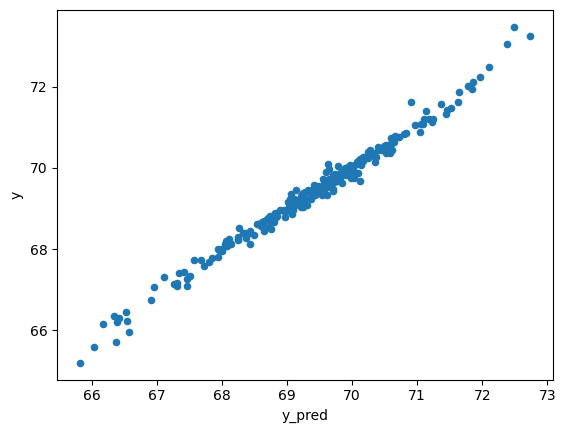

In [15]:
if W_exists:
    y_predictions = y_model.predict(X)
    df_Ys = pd.DataFrame({'y': y, 'y_pred': y_predictions, 'Weight': W})
    df_Ys.plot.scatter(x='y_pred', y='y', c='Weight', colormap='viridis')

else:
    y_predictions = y_model.predict(X)
    df_Ys = pd.DataFrame({'y': y, 'y_pred': y_predictions})
    df_Ys.plot.scatter(x='y_pred', y='y')

# Explainer (shap)

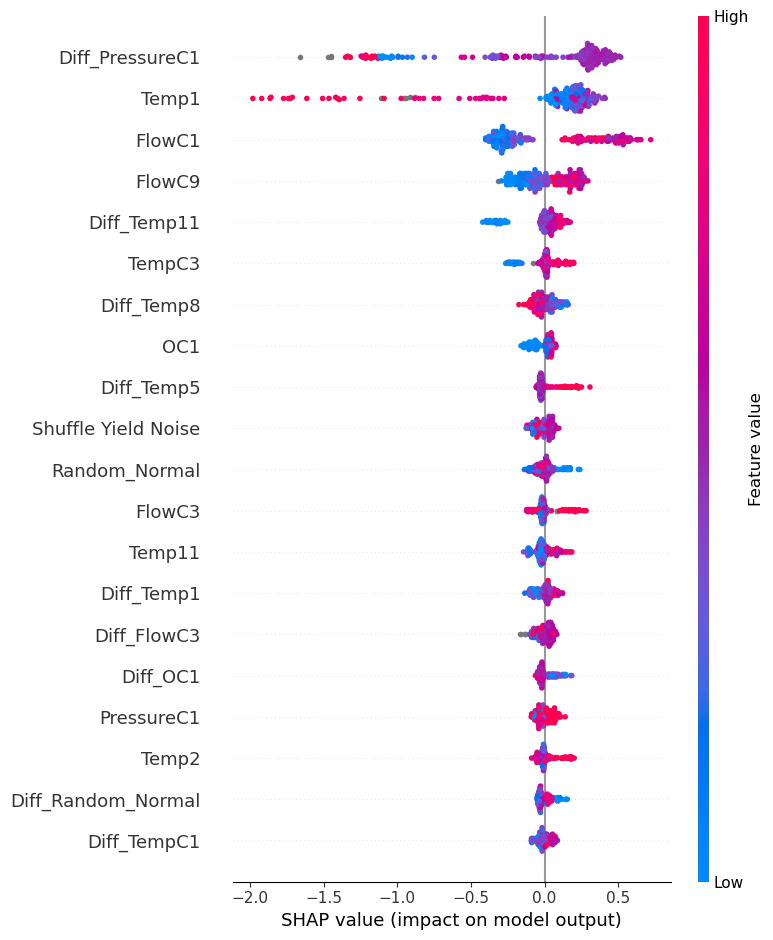

In [16]:
explainer_lgbm = shap.TreeExplainer(lgbm, feature_perturbation='tree_path_dependent') #by default if do not provide any backgound dataset: tree_path_dependent
shap_values_lgbm = explainer_lgbm.shap_values(X)

if is_plotting:
    shap.summary_plot(shap_values_lgbm, X)

In [17]:

df_shap_values = pd.DataFrame(shap_values_lgbm, index=X.index, columns=X.columns)

shap_lgbm_abs = abs(shap_values_lgbm)

mean_shap = shap_lgbm_abs.mean(axis=0)
std_shap = shap_lgbm_abs.std(axis=0)

#for some features,shap values always equal to 0 --> mean_shap contains null values
#for the ones that are null put an extremely small values?
mean_shap[np.where(mean_shap==0)] = 1e-9
CoefVariance_shap = std_shap/mean_shap 

#table of the mean and std shap
df_global_shap_values = pd.DataFrame({'Tags':X.columns,
                     'mean':mean_shap,
                     'std':std_shap,
                     'CoefVariance':CoefVariance_shap})

df_global_shap_values.sort_values(by='mean', ascending=False, inplace=True)

col_list_by_mean_shap = df_global_shap_values['Tags'].tolist()

# Reodering cloumns by shap mean value
X = X[col_list_by_mean_shap]
df_shap_values = df_shap_values[col_list_by_mean_shap]

list_ordered_factors = col_list_by_mean_shap
index_noise_shuffle = list_ordered_factors.index('Shuffle Yield Noise')
index_noise_normal = list_ordered_factors.index('Normal Noise')
index_noise_uni = list_ordered_factors.index('Uniform Noise')
min_index_noise = min(index_noise_shuffle,index_noise_normal,index_noise_uni)

col_name_noise = col_list_by_mean_shap[min_index_noise]
# Drop columns which SHAP average is below noise to ratio cut

# Gets the noise mean value
#noise_impact = float(df_global_shap_values['mean'].tail(1))
noise_impact = df_global_shap_values.set_index('Tags')['mean'][col_name_noise]
noise_cut_impact = signal_to_noise * noise_impact

# Finds columns with higher impact
bool_columns_after_noise_ratio_cut = df_global_shap_values['mean'].gt(noise_cut_impact)
col_list_after_noise_ratio_cut = df_global_shap_values[bool_columns_after_noise_ratio_cut]['Tags'].tolist()
print('list of columns above noise ratio: ', col_list_after_noise_ratio_cut)


# Appends noise column to visualize baseline
col_list_after_noise_ratio_cut.append(col_name_noise)

if 'SHAP_row_index' in col_list_after_noise_ratio_cut:
    # if a counter is important, this should be found by time index
    col_list_after_noise_ratio_cut.remove('SHAP_row_index')

# Alternative list with columns which SHAP average is just below noise (no noise ratio)
col_list_by_mean_shap_cut = col_list_by_mean_shap[0:(min_index_noise+1)]

# Simple index
# X['SHAP_row_index'] = range(1, len(X) + 1)

try:
    # Match JMP row index in case there were excluded rows
    X['SHAP_row_index'] = JMP_row_index
except:
    # Failed using JMP row indexes
    print('JMP row index was not passed properly to the solution.')
    X['SHAP_row_index'] = range(1, len(X) + 1)

X_SHAP_row_index = X['SHAP_row_index'].copy() # copy index before deleting
X.drop(['SHAP_row_index'], axis=1, inplace=True)


# TODO, which one is better?
# X = X[col_list_by_mean_shap_cut]
X = X[col_list_after_noise_ratio_cut]

#X_normalized = (X-X.min())/(X.max()-X.min()) # not robust to outliers
X_normalized = (X-X.quantile(0.03))/(X.quantile(0.97)-X.quantile(0.03))
X_normalized = X_normalized.clip(0, 1)

# add SHAP row index again
#X_normalized['SHAP_row_index'] = X_SHAP_row_index

if 'SHAP_row_index' in df_shap_values.columns:
    df_shap_values.drop(['SHAP_row_index'], axis=1, inplace=True)
# df_shap_values = df_shap_values[col_list_by_mean_shap_cut]
df_shap_values = df_shap_values[col_list_after_noise_ratio_cut]

# Full list until noise (no signal ratio used in case user wants to reduce it)
df_global_shap_values = df_global_shap_values.iloc[0:(min_index_noise+1),:]

toc = time.time() - tic
print('SHAP time [s]:', round(toc, 1))
tic = time.time()



list of columns above noise ratio:  ['Diff_PressureC1', 'Temp1', 'FlowC1', 'FlowC9', 'Diff_Temp11', 'TempC3', 'Diff_Temp8', 'OC1', 'Diff_Temp5', 'Shuffle Yield Noise', 'Random_Normal', 'FlowC3', 'Temp11', 'Diff_Temp1', 'Diff_FlowC3', 'Diff_OC1', 'PressureC1', 'Temp2', 'Diff_Random_Normal', 'Diff_TempC1', 'Diff_FlowC1', 'Temp6', 'Diff_Temp4', 'Diff_Random_Uniform', 'Diff_FlowC9', 'Diff_Temp2', 'FlowC4', 'Diff_VapourPressure', 'Temp8', 'Diff_FlowC2', 'Normal Noise', 'Temp5', 'Temp4', 'Diff_TempC3', 'Diff_Temp7', 'Temp9', 'Diff_FlowC4', 'Diff_Temp9', 'Random_Uniform', 'Temp10', 'VapourPressure', 'TempC1', 'Diff_Temp10', 'Uniform Noise', 'FlowC2', 'Temp7', 'Temp3', 'Temp12', 'Diff_TempC2', 'TempC2', 'Diff_Temp6', 'Diff_Temp12', 'Diff_Temp3']
SHAP time [s]: 0.9


In [18]:
# Tables for shap plots in JMP

if t_exists:
    df_shap_values = pd.concat([t, y, df_shap_values], axis=1)
    
    # Adds original row index as unique identifier
    # TODO use JMP index instead (in case there were excluded rows)
    df_shap_values.insert(0, X_SHAP_row_index.name, X_SHAP_row_index.values)
    
    df_shap_values_melted = df_shap_values.melt(id_vars=[X_SHAP_row_index.name, t.name, y.name])
    df_shap_values_melted.columns = [X_SHAP_row_index.name, t.name, y.name, 'tag', 'shap(value)'] 
    
    X_melted = X.melt()
    X_melted.columns = ['tag', 'value']
    
    X_norm_melted = X_normalized.melt()
    X_norm_melted.columns = ['tag', 'norm(value)']
    
    df_shap_plot_table = pd.concat([df_shap_values_melted,
                                    X_melted['value'],
                                    X_norm_melted['norm(value)']],
                                   axis=1)
    
else:
    df_shap_values = pd.concat([y, df_shap_values], axis=1)
    
    # Adds original row index as unique identifier
    df_shap_values.insert(0, X_SHAP_row_index.name, X_SHAP_row_index.values)
    
    df_shap_values_melted = df_shap_values.melt(id_vars=[X_SHAP_row_index.name, y.name])
    df_shap_values_melted.columns = [X_SHAP_row_index.name, y.name, 'tag', 'shap(value)'] 
                                    
    X_melted = X.melt()
    X_melted.columns = ['tag', 'value']
    
    X_norm_melted = X_normalized.melt()
    X_norm_melted.columns = ['tag', 'norm(value)']
    
    df_shap_plot_table = pd.concat([df_shap_values_melted,
                                    X_melted['value'],
                                    X_norm_melted['norm(value)']],
                                   axis=1)



In [19]:
# Exporting files to temp CSVs

In [20]:
df_shap_values_path_csv = os.path.join(temp_data_path,'df_shap_values.csv')
df_global_shap_values_path_csv = os.path.join(temp_data_path,'df_global_shap_values.csv')
df_shap_plot_table_path_csv = os.path.join(temp_data_path,'df_shap_plot_table.csv')

df_shap_values.to_csv(df_shap_values_path_csv)
df_global_shap_values.to_csv(df_global_shap_values_path_csv)
df_shap_plot_table.to_csv(df_shap_plot_table_path_csv)


toc = time.time() - tic
print('Exporting time [s]:', round(toc, 2))
tic = time.time()


Exporting time [s]: 0.28


In [21]:
# Visualization of tables in Notebook

In [22]:
df_shap_values

,SHAP_row_index,Date,yield,Diff_PressureC1,Temp1,FlowC1,FlowC9,Diff_Temp11,TempC3,Diff_Temp8,...,FlowC2,Temp7,Temp3,Temp12,Diff_TempC2,TempC2,Diff_Temp6,Diff_Temp12,Diff_Temp3,Shuffle Yield Noise
1,7,2016-09-04,69.161052,-1.474835,0.145498,0.369954,0.049590,0.034496,0.006298,-0.045578,...,0.006871,0.006357,0.012968,-0.000287,0.001361,0.000523,0.009157,0.008326,0.000242,-0.059273
2,8,2016-09-06,71.399191,0.353341,0.163862,0.349506,0.159948,-0.272461,0.018353,0.114899,...,0.012091,0.018998,0.009612,0.000850,-0.001856,0.000803,-0.000263,-0.000482,0.000460,0.057983
3,9,2016-09-09,70.125880,0.262535,0.213821,0.230714,0.147429,0.045295,-0.000215,-0.063497,...,0.009712,-0.010480,0.001228,0.001529,-0.004557,0.000803,-0.000331,-0.000853,0.001092,0.030964
4,10,2016-09-11,69.726319,0.358547,0.115261,0.119189,0.081931,0.045452,-0.015942,-0.075332,...,0.019630,0.012162,0.002434,0.002688,-0.001856,0.000668,-0.000088,-0.000311,0.000460,-0.038273
5,11,2016-09-13,67.777871,-1.105693,-0.916521,0.190119,0.073998,0.026850,0.004529,0.101847,...,-0.004975,0.010894,0.004829,0.003601,0.002891,0.001098,-0.001067,-0.000674,-0.001140,0.027863
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
243,249,2019-01-26,69.037071,0.247455,0.214740,-0.283969,-0.253028,0.005095,0.015389,0.015861,...,0.005897,-0.001553,0.000566,-0.006712,-0.004710,0.001066,-0.001485,-0.000552,0.003303,0.030188
244,250,2019-01-28,69.202425,-0.047581,0.206856,-0.348104,-0.122073,0.080384,0.026462,-0.034455,...,0.008995,-0.009182,0.007317,-0.004089,-0.002138,0.001302,-0.001377,-0.001329,0.000804,0.031620
245,251,2019-01-31,69.409546,0.322054,0.237202,-0.310526,-0.178362,-0.024156,0.017000,0.054220,...,0.011867,-0.000682,0.002483,-0.001805,0.007340,0.001474,-0.000633,-0.000994,-0.000839,-0.010708
246,252,2019-02-03,69.072711,0.281583,0.198565,-0.284177,-0.249837,-0.010885,0.009853,-0.039579,...,0.013707,-0.003288,-0.000876,0.002818,-0.004710,0.000546,-0.001274,-0.000409,-0.003447,-0.022752


In [23]:
y.name

'yield'

In [24]:
# df_shap_values.describe()

In [25]:
df_global_shap_values

,Tags,mean,std,CoefVariance
29,Diff_PressureC1,0.453061,0.336563,0.742864
0,Temp1,0.337624,0.392071,1.161264
1,FlowC1,0.316411,0.122712,0.387826
2,FlowC9,0.140277,0.079151,0.564245
30,Diff_Temp11,0.071624,0.094462,1.318871
3,TempC3,0.053615,0.070370,1.312500
41,Diff_Temp8,0.052115,0.037567,0.720838
9,OC1,0.048533,0.031281,0.644530
46,Diff_Temp5,0.046987,0.058187,1.238375
52,Shuffle Yield Noise,0.043802,0.026972,0.615773


In [26]:
#df_global_shap_values.describe()

In [27]:
df_shap_plot_table

,SHAP_row_index,Date,yield,tag,shap(value),value,norm(value)
0,7,2016-09-04,69.161052,Diff_PressureC1,-1.474835,NaN,NaN
1,8,2016-09-06,71.399191,Diff_PressureC1,0.353341,0.188000,0.343468
2,9,2016-09-09,70.125880,Diff_PressureC1,0.262535,-0.257500,0.315188
3,10,2016-09-11,69.726319,Diff_PressureC1,0.358547,0.034700,0.333737
4,11,2016-09-13,67.777871,Diff_PressureC1,-1.105693,-4.070100,0.073166
...,...,...,...,...,...,...,...
13009,249,2019-01-26,69.037071,Shuffle Yield Noise,0.030188,70.018181,0.658824
13010,250,2019-01-28,69.202425,Shuffle Yield Noise,0.031620,69.612811,0.586556
13011,251,2019-01-31,69.409546,Shuffle Yield Noise,-0.010708,73.242426,1.000000
13012,252,2019-02-03,69.072711,Shuffle Yield Noise,-0.022752,68.513358,0.390550


In [28]:
#df_shap_plot_table.describe()

# UMAP Dimensionality reduction for selected inputs

In [29]:
# X has already the RF selected features ordered by importance
X.head()

,Diff_PressureC1,Temp1,FlowC1,FlowC9,Diff_Temp11,TempC3,Diff_Temp8,OC1,Diff_Temp5,Shuffle Yield Noise,...,FlowC2,Temp7,Temp3,Temp12,Diff_TempC2,TempC2,Diff_Temp6,Diff_Temp12,Diff_Temp3,Shuffle Yield Noise
1,NaN,120.8903,493.8452,99.8533,NaN,169.9978,NaN,4.1296,NaN,70.726714,...,72.6067,1106.8098,480.9020,478.9996,NaN,479.2014,NaN,NaN,NaN,70.726714
2,0.1880,119.4786,429.0580,85.8233,-4.3980,166.9747,-9.1383,3.7133,0.5382,69.735671,...,72.0667,1090.3263,480.9136,479.0630,-0.0416,479.1598,-0.2546,0.0634,0.0116,69.735671
3,-0.2575,124.8390,414.0616,82.6411,0.6334,171.4144,4.3810,3.0900,5.8511,69.458188,...,71.5083,1126.8611,483.9983,482.6684,3.2229,482.3827,2.2629,3.6054,3.0847,69.458188
4,0.0347,121.6020,505.6681,99.9829,0.6089,169.5163,12.3445,4.6217,0.7292,68.403371,...,71.4267,1087.4791,485.1037,483.9492,1.2109,483.5936,2.0776,1.2808,1.1054,68.403371
5,-4.0701,NaN,498.9423,99.6483,0.2217,167.9932,-9.7981,4.6708,-6.2620,69.072711,...,70.4600,1087.1493,479.7561,478.2151,-5.5336,478.0600,-5.7932,-5.7341,-5.3476,69.072711


N of umap dimensions 2
Distance metric: euclidean
N of rows for finite differences 1


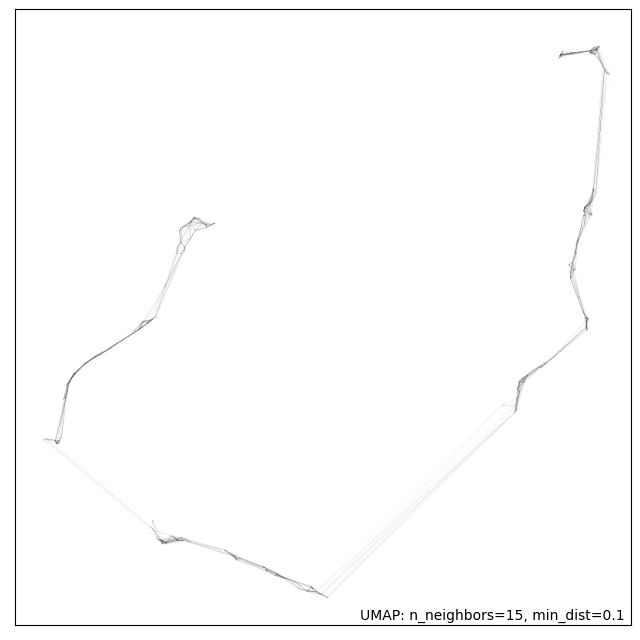

In [30]:
# Function was defined above

if not(is_unspervised_learning):
    n_umap_components = int(JMP_user_parameters['NdimUMAP'])
    distance = str(JMP_user_parameters['metric'][0])
    
    df_umap, n_umap_components = umap_princ_components(X, n_umap_components, distance)

In [31]:
# DO NOT EDIT THIS CELL

# This file is generated only if all the notebook was executed correctly
# JMP will stop if doesn't find it
python_execution_check_csv = os.path.join(temp_data_path,'python_execution.csv')

try:
    os.remove(python_execution_check_csv)
except:
    print('Generating file to confirm python execution')

pd.DataFrame({'Python': [1]}).to_csv(python_execution_check_csv)

#  END